In [1]:
# %matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")

from rdkit.Chem import Descriptors
from rdkit import Chem 
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

In [2]:
model = word2vec.Word2Vec.load('rdkit/model_300dim.pkl')
hiv = pd.read_csv('rdkit/HIV.csv')
hiv.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


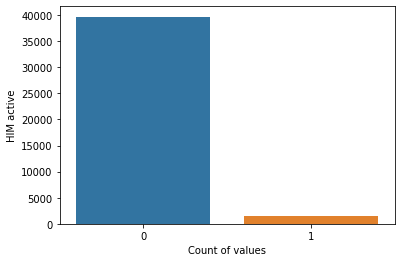

In [3]:
sns.countplot(data = hiv, x='HIV_active', orient='v')
plt.ylabel('HIM active')
plt.xlabel('Count of values')
plt.show()

In [4]:
#Transform SMILES to MOL
hiv['mol'] = hiv['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

#MOL to feature
hiv['tpsa'] = hiv['mol'].apply(lambda x: Descriptors.TPSA(x))
hiv['mol_w'] = hiv['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
hiv['num_valence_electrons'] = hiv['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
hiv['num_heteroatoms'] = hiv['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))
# MOL to radius 1, morgan fingerprint, aka sentence
hiv['sentence'] = hiv['mol'].apply(lambda x: MolSentence(mol2alt_sentence(x, 1))) 
# sentence to mol2vec 
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
molvec = [DfVec(x) for x in sentences2vec(hiv['sentence'], model, unseen='UNK')]
X_mol = np.array([x.vec for x in molvec]) # 300 dimensions
# X_mol = pd.DataFrame(X_mol)
# hiv = pd.concat((hiv, X_mol), axis=1)

In [5]:
random_state = 1
# 300 dimensions to 10 dimension
pca_1d = PCA(100, random_state=random_state)
X_mol = pca_1d.fit_transform(X_mol)
X_mol = pd.DataFrame(X_mol)

hiv = pd.concat((hiv, X_mol), axis=1)

In [75]:
y = hiv.HIV_active.values
X = hiv.drop(columns=['smiles', 'activity', 'HIV_active', 'mol', 'sentence'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [76]:
X.columns

Index([                 'tpsa',                 'mol_w',
       'num_valence_electrons',       'num_heteroatoms',
                             0,                       1,
                             2,                       3,
                             4,                       5,
       ...
                            90,                      91,
                            92,                      93,
                            94,                      95,
                            96,                      97,
                            98,                      99],
      dtype='object', length=104)

In [132]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve, f1_score
def evaluation_roc(model, X_test, y_test):
    preds = model.predict_proba(X_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)    
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'g', label = f'AUC = {roc_auc:.3}')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
        

def evaluation_pr(model, X_test, y_test):
    preds = model.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    f1 = f1_score(y_test, (preds > 0.5) )
    
    plt.title('PR Curve')
    plt.plot(recall, precision, 'g', label = f'f1 = {f1:.3}')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('precision')
    plt.xlabel('recall')
    plt.show()
            


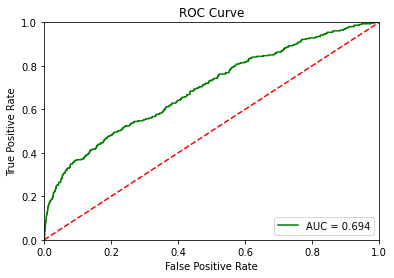

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X_train1 = StandardScaler().fit_transform(X_train[['tpsa' , 'mol_w', 'num_valence_electrons', 'num_heteroatoms']])
X_test1 = StandardScaler().fit_transform(X_test[['tpsa' , 'mol_w', 'num_valence_electrons', 'num_heteroatoms']])

# lr = LogisticRegression()
# lr.fit(X_train1, y_train)

# evaluation_roc(lr, X_test1, y_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)

evaluation_roc(lr, X_test, y_test)

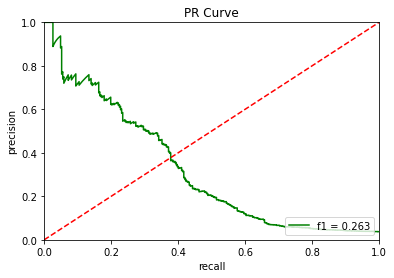

In [134]:
X_train2 = StandardScaler().fit_transform(X_train)
X_test2 = StandardScaler().fit_transform(X_test)

lr = LogisticRegression()
lr.fit(X_train2, y_train)

evaluation_pr(lr, X_test2, y_test)

In [135]:
from xgboost.sklearn import XGBClassifier

clf = XGBClassifier(
        n_estimators=100,
        learning_rate= 0.3, 
        max_depth=2, 
        min_child_weight=1,     
        scale_pos_weight=30,
        seed=1000 )

In [136]:
clf.fit(X_train2, y_train,eval_metric='auc')

XGBClassifier(learning_rate=0.3, max_depth=2, scale_pos_weight=30, seed=1000)

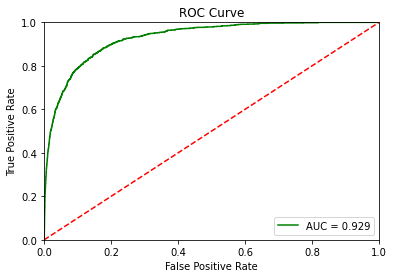

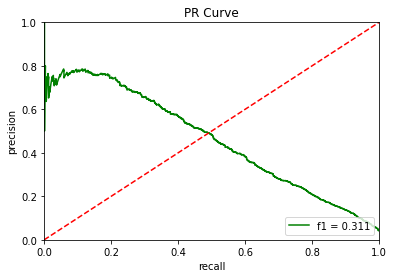

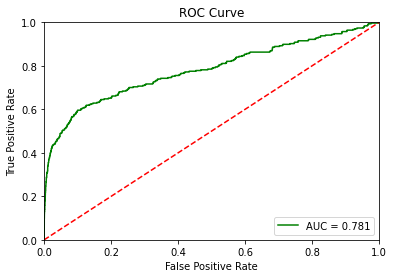

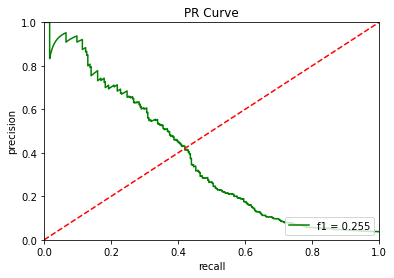

In [137]:
evaluation_roc(clf, X_train2, y_train)
evaluation_pr(clf, X_train2, y_train)

evaluation_roc(clf, X_test2, y_test)
evaluation_pr(clf, X_test2, y_test)

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
# generate dataset

# define model
model = XGBClassifier()
# define grid
param_grid = {'max_depth': [2, 3, 4,],
              'n_estimators': [200],
              'learning_rate': [0.3], 
              'scale_pos_weight': [1,],
              'min_child_weight': [32, 64, 128],
             'max_delta_step': [0, 1, 5, 10]}

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1_micro')
# execute the grid search
grid_result = grid.fit(X_train2, y_train)

# report the best configuration
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.3462775702540485 using {'learning_rate': 0.3, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 32, 'n_estimators': 200, 'scale_pos_weight': 1}
0.278885 (0.036374) with: {'learning_rate': 0.3, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 32, 'n_estimators': 200, 'scale_pos_weight': 1}
0.263047 (0.035395) with: {'learning_rate': 0.3, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 64, 'n_estimators': 200, 'scale_pos_weight': 1}
0.258660 (0.036451) with: {'learning_rate': 0.3, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 128, 'n_estimators': 200, 'scale_pos_weight': 1}
0.320072 (0.028452) with: {'learning_rate': 0.3, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 32, 'n_estimators': 200, 'scale_pos_weight': 1}
0.300435 (0.026794) with: {'learning_rate': 0.3, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 64, 'n_estimators': 200, 'scale_pos_weight': 1}
0.282092 (0.026181) with: {'learning_rate': 0.3, 'max_delta_step': 0, 

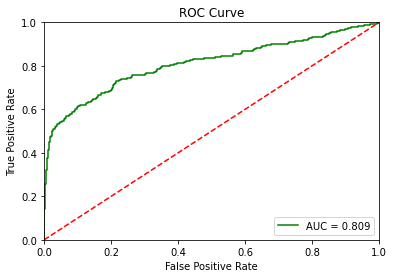

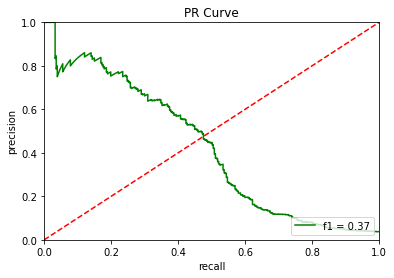

In [138]:
clf = XGBClassifier(**grid_result.best_params_)
clf.fit(X_train2, y_train) 
evaluation_roc(clf, X_test2, y_test)
evaluation_pr(clf, X_test2, y_test)